## 1. Import dependecies

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from scipy.optimize import curve_fit, fsolve

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

In [2]:
# install lmfit regression module
#! pip install lmfit

# Import lmfit module
from lmfit.models import ConstantModel, StepModel
from lmfit import Model, Minimizer, Parameters, report_fit

## Error calcualtion with uncertainties package

In [3]:
# install the uncertainties package
#!pip install --upgrade uncertainties
from uncertainties import ufloat
from uncertainties import unumpy

#test
arr = unumpy.uarray([1, 2], [0.01, 0.002])
print (arr)

xa = 0.20
xb = 0.01
xe = ufloat(xa , xb)  # x = 0.20+/-0.01
print(xe)

[1.0+/-0.01 2.0+/-0.002]
0.200+/-0.010


In [4]:
# Define the sigmoid function
# define h : Interval, c: minimum, a:logistic growth rate or steepness, x0: x_mid point 
def sigmoid(x, h, a, x0, c):
    return h / (1. + np.exp(-a * (x - x0))) + c

# create a fit Model that wraps the sigmoid function
smodel = Model(sigmoid)
# assign initial values of parameters and other attributes
params = smodel.make_params(h=5, a=1, x0=0, c=10)


# definition of sigmoid and gaussian fuctions
def fit_sig_err(x, y, y_err):
    
    # nonlinear least squares curve fitting with sigmoid fuction

    OP= smodel.fit(y, params, bounds=([-20, -10, -0.7, 0], [20, 10, 0.7, 80]), x=x)

    #print parameters
    # print(OP.fit_report())
    print('-------------------------------')
    print('Parameter    Value       Stderr')
    for name, param in OP.params.items():
        print('{!s:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))

    max_c = OP.params['c'].value
    int_h = OP.params['h'].value   
    rate_a = OP.params['a'].value   
    mid_x0 = OP.params['x0'].value 
    
  
    # print the y_max, y_min, y_90, and y_10 values
    y_maxp = ufloat(max_c, OP.params['c'].stderr)
    y_90p = ufloat(max_c, OP.params['c'].stderr) + 0.1*ufloat(int_h, OP.params['h'].stderr)
    y_10p = ufloat(max_c, OP.params['c'].stderr) + 0.9*ufloat(int_h, OP.params['h'].stderr)
    y_minp = ufloat(max_c, OP.params['c'].stderr) + ufloat(int_h, OP.params['h'].stderr)
    print(f"y_max : {y_maxp:.3f}, y_90: {y_90p:.3f},  y_10: {y_10p:.3f},  y_min: {y_minp:.3f}")
        
       
    # define sigmiod 90, 10% fuction.
    y_90 = max_c + 0.1*int_h
    y_90perr = y_90  + (OP.params['h'].stderr)
    y_90merr = y_90 - (OP.params['h'].stderr)
    y_10 = max_c + 0.9*int_h
    y_10perr = y_10  + (OP.params['h'].stderr)
    y_10merr = y_10  - (OP.params['h'].stderr)
    
    
    y_values = [y_90, y_90perr, y_90merr, y_10, y_10perr, y_10merr ]
    
    p_list =[]
    
    for y_val in y_values:
        def fp(p) :
            f1 = sigmoid(p, int_h, rate_a, mid_x0, max_c) - y_val
            return f1
        
        p = fsolve(fp,0)[0]
        p_list.append(p)
        
    err_90 = ((p_list[0]-p_list[1])**2 +(p_list[0]-p_list[2])**2)**0.5
    err_10 = ((p_list[3]-p_list[4])**2 +(p_list[3]-p_list[5])**2)**0.5
    x_90 = ufloat(p_list[0], err_90)
    x_10 = ufloat(p_list[3], err_10)
    width = x_90-x_10
    R_squared = r2_score(OP.best_fit, y)
    print(f"x_90: {x_90:.4f}, x_10: {x_10:.4f}, width: {width:.5f}, R_2: {R_squared:.4f}")    
     
    
    # gaussian process model setup
    # Trnasforse
    X = np.atleast_2d(x).T
    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    mesh = np.atleast_2d(np.linspace(-3, 3, 100)).T

    # Instantiate a Gaussian Process model
    kernel = RBF() + ConstantKernel(constant_value=2)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=y_err ** 2,
                                  n_restarts_optimizer=10)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, OP.best_fit)
    
   
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(mesh, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    
    fig, ax = plt.subplots(figsize=(6,3.5))
    ax.plot(x, OP.best_fit, 'b:', label=r'Sigmoid')
    ax.errorbar(x, y, y_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='Measured value')
    ax.fill(np.concatenate([mesh, mesh[::-1]]),
             np.concatenate([y_pred - 2 * sigma,
                            (y_pred + 2 * sigma)[::-1]]),
             alpha=.2, fc='b', ec='None', label='fitting 2-$\sigma$ band')

    ax.axvline(x=mid_x0, color='k', linestyle='--', label='Center' )
    ax.axvline(x=p_list[0], color='g', linestyle='--', label='10-90 interval')
    ax.axvline(x=p_list[3], color='g', linestyle='--')
    ax.text(0.48, 0.09, r'$\delta$={:.2f} nm'.format(width), ha='center', va='center', transform=ax.transAxes, size=13, color="g", bbox=dict(facecolor='white', edgecolor='white'))
    ax.legend(loc='best')
    plt.xlim([-3, 3])
    plt.xlabel("Distance (nm)", fontsize=14)
    plt.ylabel('Concentration (%)', fontsize=14)
    plt.show()
    return {'OP_params':OP.params.items(),'width': width}

# <end sigmoid fuction>




 data/Re_700_1h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.37083     0.12982
a           2.64564     0.20818
x0         -0.30340     0.03350
c          79.93524     0.10141
y_max : 79.935+/-0.101, y_90: 79.398+/-0.102,  y_10: 75.101+/-0.155,  y_min: 74.564+/-0.165
x_90: -1.1339+/-0.1470, x_10: 0.5271+/-0.1470, width: -1.66102+/-0.20794, R_2: 0.9933


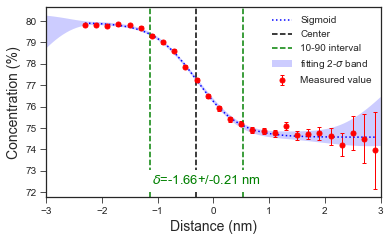


 Element Al
-------------------------------
Parameter    Value       Stderr
h          11.51540     0.15452
a           2.41710     0.10039
x0         -0.21812     0.01911
c           7.22380     0.11780
y_max : 7.224+/-0.118, y_90: 8.375+/-0.119,  y_10: 17.588+/-0.182,  y_min: 18.739+/-0.194
x_90: -1.1272+/-0.0879, x_10: 0.6909+/-0.0879, width: -1.81807+/-0.12426, R_2: 0.9981


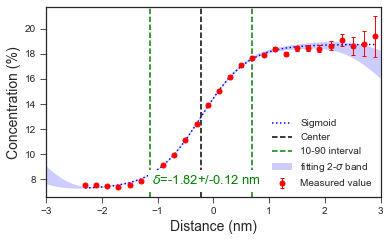


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -5.47735     0.06826
a           2.30632     0.08750
x0         -0.10915     0.01808
c          10.51353     0.05030
y_max : 10.514+/-0.050, y_90: 9.966+/-0.051,  y_10: 5.584+/-0.079,  y_min: 5.036+/-0.085
x_90: -1.0618+/-0.0854, x_10: 0.8435+/-0.0854, width: -1.90539+/-0.12083, R_2: 0.9984


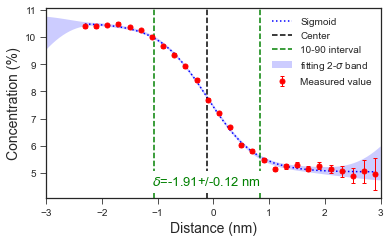


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.62671     0.02724
a           2.71320     0.38980
x0         -0.32043     0.05979
c           2.29015     0.02138
y_max : 2.290+/-0.021, y_90: 2.227+/-0.022,  y_10: 1.726+/-0.033,  y_min: 1.663+/-0.035
x_90: -1.1303+/-0.2733, x_10: 0.4894+/-0.2733, width: -1.61966+/-0.38651, R_2: 0.9779


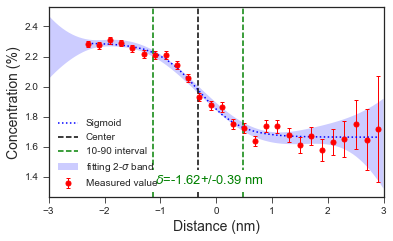

In [5]:
# interfacial width for all times we've experinced. 

# glob module is used to retrieve files/pathnames matching a specified pattern
from glob import glob

filenames = glob('data/Re_700_1h.csv')
elements = ['Ni', 'Al', 'Cr', 'Re']
errors = ['Ni_Err', 'Al_Err', 'Cr_Err', 'Re_Err']

width =[]

for i in filenames:
    # import csv data
    df= pd.read_csv(i)
    print ('\n\n\n', i)
    # maximun, Minimum, 90%, 10%, x-widthe using for-loop 
    for i, j in zip(elements, errors):
        # assigne x and y values
        x = df['distance'].to_numpy()
        y = df[i].to_numpy()
        y_err = df[j].to_numpy()
        print("\n Element", i)
        fit_sig_err(x, y, y_err)




 data\Re_700_025h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.29736     0.12254
a           2.32000     0.15329
x0         -0.11855     0.03309
c          78.90774     0.04613
y_max : 78.908+/-0.046, y_90: 78.378+/-0.048,  y_10: 74.140+/-0.120,  y_min: 73.610+/-0.131
x_90: -1.0656+/-0.1601, x_10: 0.8285+/-0.1601, width: -1.89416+/-0.22647, R_2: 0.9947


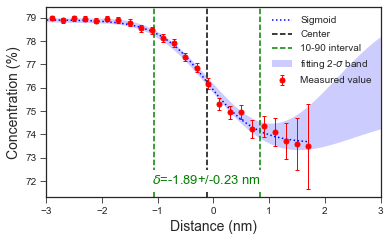


 Element Al
-------------------------------
Parameter    Value       Stderr
h           9.72903     0.14430
a           2.33823     0.10103
x0         -0.15652     0.02136
c           9.42288     0.05611
y_max : 9.423+/-0.056, y_90: 10.396+/-0.058,  y_10: 18.179+/-0.141,  y_min: 19.152+/-0.155
x_90: -1.0962+/-0.1006, x_10: 0.7832+/-0.1006, width: -1.87939+/-0.14222, R_2: 0.9977


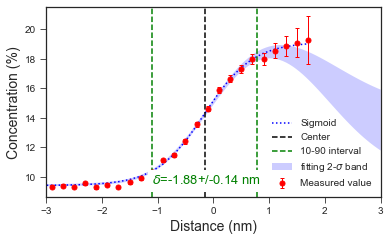


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -3.77113     0.08429
a           2.37677     0.16130
x0         -0.24491     0.03271
c           9.47327     0.03514
y_max : 9.473+/-0.035, y_90: 9.096+/-0.036,  y_10: 6.079+/-0.084,  y_min: 5.702+/-0.091
x_90: -1.1694+/-0.1508, x_10: 0.6795+/-0.1508, width: -1.84892+/-0.21328, R_2: 0.9944


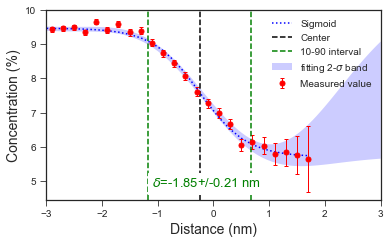


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.63787     0.03233
a           2.86048     0.46914
x0          0.00916     0.06680
c           2.19270     0.01244
y_max : 2.193+/-0.012, y_90: 2.129+/-0.013,  y_10: 1.619+/-0.032,  y_min: 1.555+/-0.035
x_90: -0.7590+/-0.3125, x_10: 0.7773+/-0.3125, width: -1.53626+/-0.44192, R_2: 0.9690


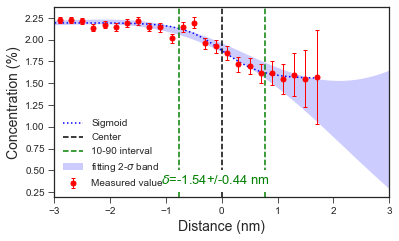




 data\Re_700_0h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -7.22157     0.61093
a           1.84984     0.18365
x0          0.70718     0.10641
c          78.26239     0.05474
y_max : 78.262+/-0.055, y_90: 77.540+/-0.082,  y_10: 71.763+/-0.553,  y_min: 71.041+/-0.613
x_90: -0.4806+/-1.1275, x_10: 1.8950+/-1.1275, width: -2.37559+/-1.59453, R_2: 0.9903


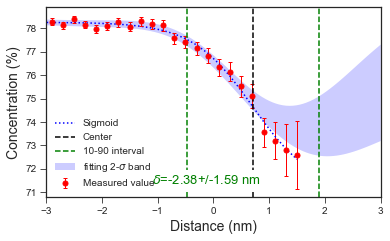


 Element Al
-------------------------------
Parameter    Value       Stderr
h          11.08801     0.52202
a           1.76328     0.11031
x0          0.52945     0.06309
c          10.44839     0.06131
y_max : 10.448+/-0.061, y_90: 11.557+/-0.081,  y_10: 20.428+/-0.474,  y_min: 21.536+/-0.526
x_90: -0.7167+/-0.4627, x_10: 1.7756+/-0.4627, width: -2.49221+/-0.65437, R_2: 0.9960


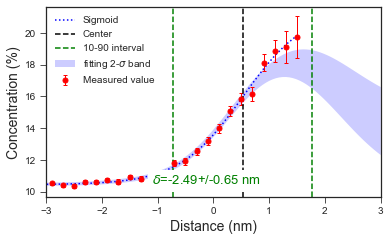


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -3.44835     0.31533
a           1.71601     0.24985
x0          0.26639     0.12908
c           9.19277     0.05343
y_max : 9.193+/-0.053, y_90: 8.848+/-0.062,  y_10: 6.089+/-0.289,  y_min: 5.744+/-0.320
x_90: -1.0140+/-1.5530, x_10: 1.5468+/-1.5530, width: -2.56086+/-2.19621, R_2: 0.9775


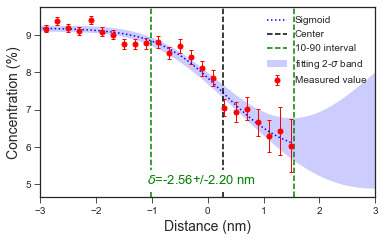


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.45539     0.03648
a           3.23362     0.89461
x0         -0.11694     0.09937
c           2.08797     0.01453
y_max : 2.088+/-0.015, y_90: 2.042+/-0.015,  y_10: 1.678+/-0.036,  y_min: 1.633+/-0.039
x_90: -0.7964+/-0.5666, x_10: 0.5626+/-0.5666, width: -1.35899+/-0.80122, R_2: 0.9182


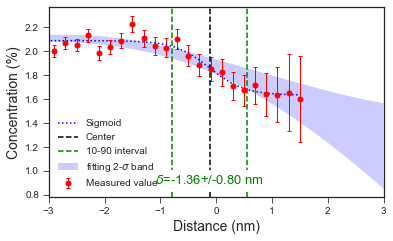




 data\Re_700_1024h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.42920     0.04743
a           4.57293     0.34857
x0         -0.03472     0.01914
c          80.13322     0.03313
y_max : 80.133+/-0.033, y_90: 79.690+/-0.033,  y_10: 76.147+/-0.054,  y_min: 75.704+/-0.058
x_90: -0.5152+/-0.0370, x_10: 0.4458+/-0.0370, width: -0.96097+/-0.05228, R_2: 0.9951


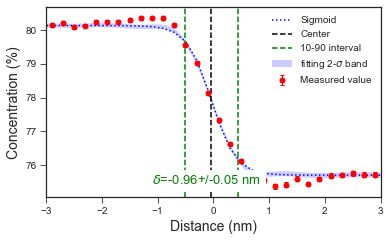


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.25446     0.02019
a           2.70628     0.02362
x0         -0.08291     0.00371
c           5.46770     0.01399
y_max : 5.468+/-0.014, y_90: 6.693+/-0.014,  y_10: 16.497+/-0.023,  y_min: 17.722+/-0.025
x_90: -0.8948+/-0.0096, x_10: 0.7290+/-0.0096, width: -1.62380+/-0.01353, R_2: 0.9999


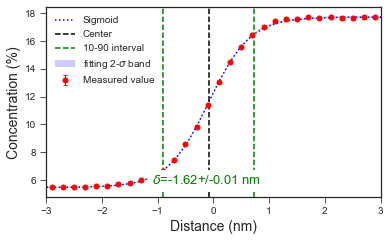


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.32328     0.01735
a           2.00513     0.02435
x0         -0.09988     0.00694
c          11.70276     0.01188
y_max : 11.703+/-0.012, y_90: 11.070+/-0.012,  y_10: 6.012+/-0.020,  y_min: 5.379+/-0.021
x_90: -1.1957+/-0.0215, x_10: 0.9959+/-0.0215, width: -2.19161+/-0.03042, R_2: 0.9997


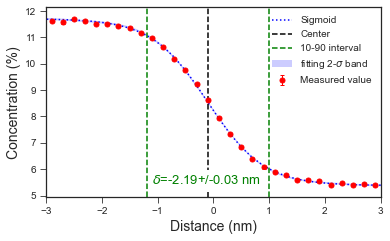


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.69039     0.00877
a           1.56561     0.03058
x0         -0.30400     0.01410
c           2.81773     0.00609
y_max : 2.818+/-0.006, y_90: 2.649+/-0.006,  y_10: 1.296+/-0.010,  y_min: 1.127+/-0.011
x_90: -1.7074+/-0.0521, x_10: 1.0994+/-0.0521, width: -2.80686+/-0.07369, R_2: 0.9992


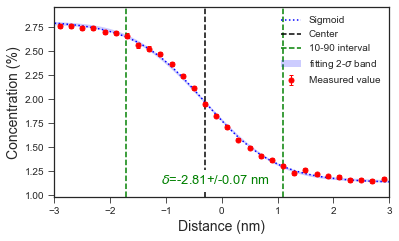




 data\Re_700_16h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.77248     0.06092
a           3.20934     0.17963
x0          0.03238     0.01997
c          79.95614     0.04074
y_max : 79.956+/-0.041, y_90: 79.479+/-0.041,  y_10: 75.661+/-0.068,  y_min: 75.184+/-0.073
x_90: -0.6523+/-0.0629, x_10: 0.7170+/-0.0629, width: -1.36927+/-0.08896, R_2: 0.9967


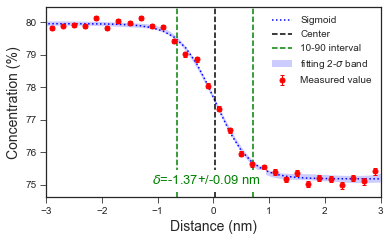


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.30840     0.06649
a           2.54905     0.05212
x0         -0.00679     0.00906
c           5.77193     0.04403
y_max : 5.772+/-0.044, y_90: 7.003+/-0.045,  y_10: 16.849+/-0.074,  y_min: 18.080+/-0.080
x_90: -0.8688+/-0.0333, x_10: 0.8552+/-0.0333, width: -1.72395+/-0.04715, R_2: 0.9995


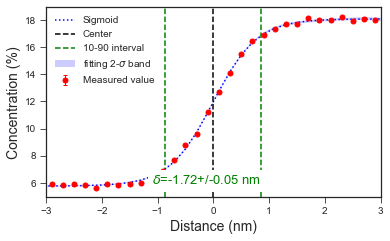


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.22513     0.02960
a           2.24626     0.03712
x0         -0.01096     0.00820
c          11.60280     0.01934
y_max : 11.603+/-0.019, y_90: 10.980+/-0.020,  y_10: 6.000+/-0.033,  y_min: 5.378+/-0.035
x_90: -0.9891+/-0.0333, x_10: 0.9672+/-0.0333, width: -1.95634+/-0.04709, R_2: 0.9996


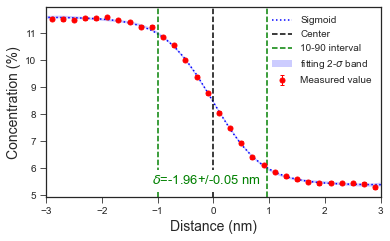


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.37110     0.01978
a           1.99741     0.09177
x0         -0.19098     0.02521
c           2.71350     0.01346
y_max : 2.714+/-0.013, y_90: 2.576+/-0.014,  y_10: 1.480+/-0.022,  y_min: 1.342+/-0.024
x_90: -1.2910+/-0.1144, x_10: 0.9091+/-0.1144, width: -2.20007+/-0.16183, R_2: 0.9971


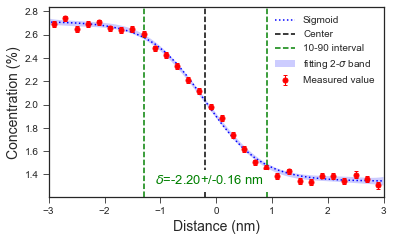




 data\Re_700_1h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.37083     0.12982
a           2.64564     0.20818
x0         -0.30340     0.03350
c          79.93524     0.10141
y_max : 79.935+/-0.101, y_90: 79.398+/-0.102,  y_10: 75.101+/-0.155,  y_min: 74.564+/-0.165
x_90: -1.1339+/-0.1470, x_10: 0.5271+/-0.1470, width: -1.66102+/-0.20794, R_2: 0.9933


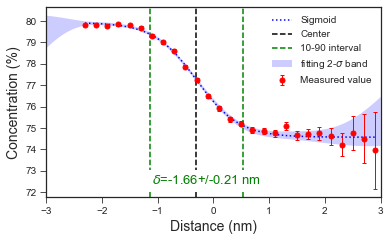


 Element Al
-------------------------------
Parameter    Value       Stderr
h          11.51540     0.15452
a           2.41710     0.10039
x0         -0.21812     0.01911
c           7.22380     0.11780
y_max : 7.224+/-0.118, y_90: 8.375+/-0.119,  y_10: 17.588+/-0.182,  y_min: 18.739+/-0.194
x_90: -1.1272+/-0.0879, x_10: 0.6909+/-0.0879, width: -1.81807+/-0.12426, R_2: 0.9981


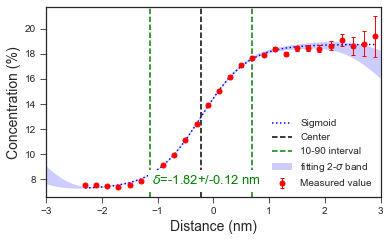


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -5.47735     0.06826
a           2.30632     0.08750
x0         -0.10915     0.01808
c          10.51353     0.05030
y_max : 10.514+/-0.050, y_90: 9.966+/-0.051,  y_10: 5.584+/-0.079,  y_min: 5.036+/-0.085
x_90: -1.0618+/-0.0854, x_10: 0.8435+/-0.0854, width: -1.90539+/-0.12083, R_2: 0.9984


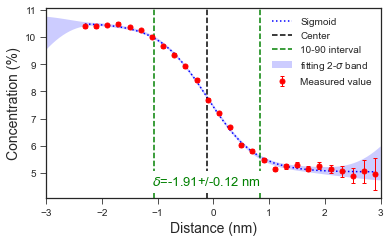


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.62671     0.02724
a           2.71320     0.38980
x0         -0.32043     0.05979
c           2.29015     0.02138
y_max : 2.290+/-0.021, y_90: 2.227+/-0.022,  y_10: 1.726+/-0.033,  y_min: 1.663+/-0.035
x_90: -1.1303+/-0.2733, x_10: 0.4894+/-0.2733, width: -1.61966+/-0.38651, R_2: 0.9779


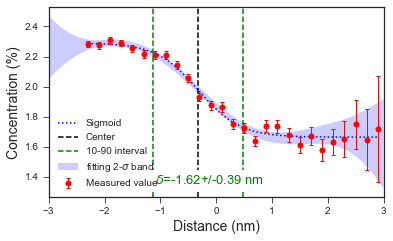




 data\Re_700_256h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.34139     0.04241
a           4.63338     0.32437
x0          0.06428     0.01735
c          80.12384     0.02930
y_max : 80.124+/-0.029, y_90: 79.690+/-0.030,  y_10: 76.217+/-0.048,  y_min: 75.782+/-0.052
x_90: -0.4099+/-0.0333, x_10: 0.5385+/-0.0333, width: -0.94843+/-0.04703, R_2: 0.9959


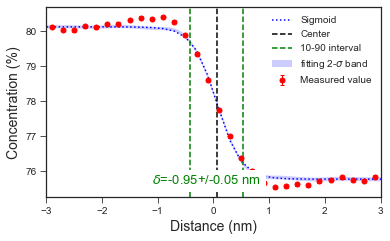


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.08908     0.01389
a           2.76694     0.01706
x0         -0.00636     0.00256
c           5.50212     0.00954
y_max : 5.502+/-0.010, y_90: 6.711+/-0.010,  y_10: 16.382+/-0.016,  y_min: 17.591+/-0.017
x_90: -0.8005+/-0.0065, x_10: 0.7877+/-0.0065, width: -1.58820+/-0.00923, R_2: 0.9999


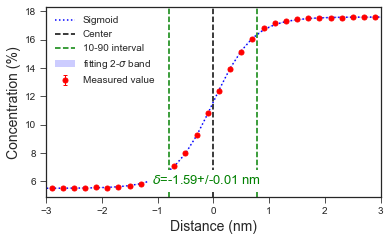


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.24017     0.01060
a           2.07298     0.01591
x0         -0.04973     0.00424
c          11.64385     0.00722
y_max : 11.644+/-0.007, y_90: 11.020+/-0.007,  y_10: 6.028+/-0.012,  y_min: 5.404+/-0.013
x_90: -1.1097+/-0.0129, x_10: 1.0102+/-0.0129, width: -2.11987+/-0.01821, R_2: 0.9999


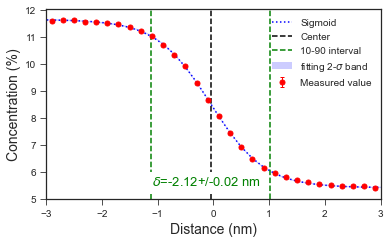


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.66692     0.00565
a           1.70711     0.02312
x0         -0.21097     0.00902
c           2.83930     0.00390
y_max : 2.839+/-0.004, y_90: 2.673+/-0.004,  y_10: 1.339+/-0.006,  y_min: 1.172+/-0.007
x_90: -1.4981+/-0.0312, x_10: 1.0761+/-0.0312, width: -2.57420+/-0.04417, R_2: 0.9996


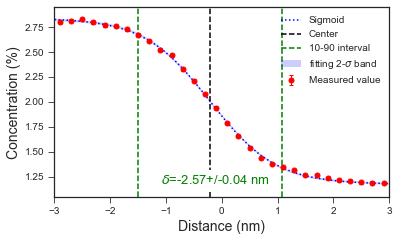




 data\Re_700_4h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.31093     0.07673
a           2.82377     0.14867
x0         -0.15224     0.02104
c          80.20169     0.05606
y_max : 80.202+/-0.056, y_90: 79.671+/-0.057,  y_10: 75.422+/-0.089,  y_min: 74.891+/-0.095
x_90: -0.9304+/-0.0811, x_10: 0.6259+/-0.0811, width: -1.55623+/-0.11466, R_2: 0.9970


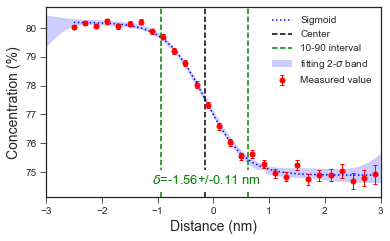


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.52184     0.12001
a           2.53107     0.08138
x0         -0.20830     0.01420
c           6.21188     0.08860
y_max : 6.212+/-0.089, y_90: 7.464+/-0.089,  y_10: 17.482+/-0.140,  y_min: 18.734+/-0.149
x_90: -1.0764+/-0.0597, x_10: 0.6598+/-0.0597, width: -1.73620+/-0.08445, R_2: 0.9988


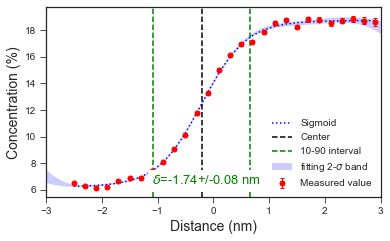


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.09278     0.08500
a           2.33582     0.10303
x0         -0.21584     0.02090
c          11.08143     0.06265
y_max : 11.081+/-0.063, y_90: 10.472+/-0.063,  y_10: 5.598+/-0.099,  y_min: 4.989+/-0.106
x_90: -1.1565+/-0.0946, x_10: 0.7248+/-0.0946, width: -1.88133+/-0.13377, R_2: 0.9978


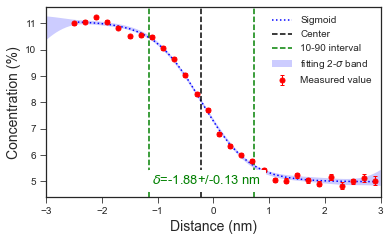


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.16210     0.03023
a           2.34952     0.18355
x0         -0.50453     0.03740
c           2.54610     0.02405
y_max : 2.546+/-0.024, y_90: 2.430+/-0.024,  y_10: 1.500+/-0.036,  y_min: 1.384+/-0.039
x_90: -1.4397+/-0.1789, x_10: 0.4306+/-0.1789, width: -1.87036+/-0.25294, R_2: 0.9930


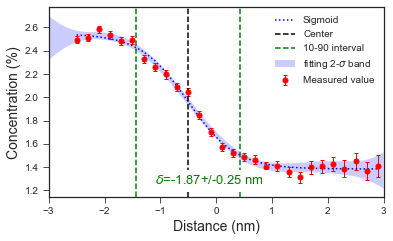




 data\Re_700_64h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.63225     0.03392
a           3.45905     0.13426
x0         -0.40611     0.01291
c          80.14281     0.02441
y_max : 80.143+/-0.024, y_90: 79.680+/-0.025,  y_10: 75.974+/-0.039,  y_min: 75.511+/-0.042
x_90: -1.0413+/-0.0333, x_10: 0.2291+/-0.0333, width: -1.27042+/-0.04715, R_2: 0.9984


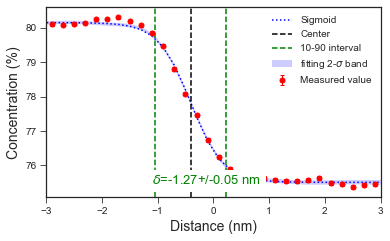


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.19063     0.02178
a           2.53479     0.01982
x0         -0.52337     0.00353
c           5.69109     0.01582
y_max : 5.691+/-0.016, y_90: 6.910+/-0.016,  y_10: 16.663+/-0.025,  y_min: 17.882+/-0.027
x_90: -1.3902+/-0.0111, x_10: 0.3435+/-0.0111, width: -1.73366+/-0.01566, R_2: 0.9999


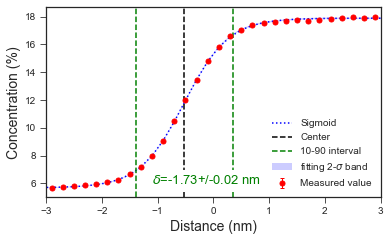


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.10156     0.01421
a           2.14874     0.01991
x0         -0.20651     0.00490
c          11.45896     0.00967
y_max : 11.459+/-0.010, y_90: 10.849+/-0.010,  y_10: 5.968+/-0.016,  y_min: 5.357+/-0.017
x_90: -1.2291+/-0.0170, x_10: 0.8161+/-0.0170, width: -2.04513+/-0.02409, R_2: 0.9999


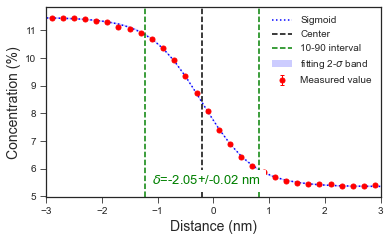


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.56040     0.00832
a           1.89780     0.03694
x0         -0.36161     0.01154
c           2.80554     0.00578
y_max : 2.806+/-0.006, y_90: 2.650+/-0.006,  y_10: 1.401+/-0.009,  y_min: 1.245+/-0.010
x_90: -1.5194+/-0.0442, x_10: 0.7962+/-0.0442, width: -2.31555+/-0.06250, R_2: 0.9994


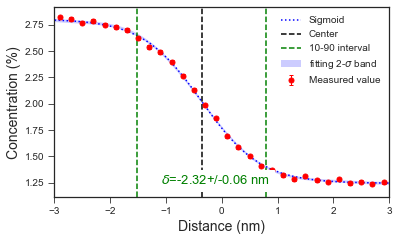

In [6]:
# interfacial width for all times we've experinced. 

# glob module is used to retrieve files/pathnames matching a specified pattern
from glob import glob

filenames = glob('data/Re_700*.csv')
elements = ['Ni', 'Al', 'Cr', 'Re']
errors = ['Ni_Err', 'Al_Err', 'Cr_Err', 'Re_Err']

width =[]

for i in filenames:
    # import csv data
    df= pd.read_csv(i)
    print ('\n\n\n', i)
    # maximun, Minimum, 90%, 10%, x-widthe using for-loop 
    for i, j in zip(elements, errors):
        # assigne x and y values
        x = df['distance'].to_numpy()
        y = df[i].to_numpy()
        y_err = df[j].to_numpy()
        print("\n Element", i)
        fit_sig_err(x, y, y_err)

In [7]:
# definition of sigmoid and gaussian fuctions
def fit_sig_errval(x, y, y_err):
    
    # nonlinear least squares curve fitting with sigmoid fuction

    OP= smodel.fit(y, params, bounds=([-20, -10, -0.7, 0], [20, 10, 0.7, 80]), x=x)

    max_c = OP.params['c'].value
    int_h = OP.params['h'].value   
    rate_a = OP.params['a'].value   
    mid_x0 = OP.params['x0'].value 
    
  
    # print the y_max, y_min, y_90, and y_10 values
    y_maxp = ufloat(max_c, OP.params['c'].stderr)
    y_90p = ufloat(max_c, OP.params['c'].stderr) + 0.1*ufloat(int_h, OP.params['h'].stderr)
    y_10p = ufloat(max_c, OP.params['c'].stderr) + 0.9*ufloat(int_h, OP.params['h'].stderr)
    y_minp = ufloat(max_c, OP.params['c'].stderr) + ufloat(int_h, OP.params['h'].stderr)
    print(f"y_max : {y_maxp:.3f}, y_90: {y_90p:.3f},  y_10: {y_10p:.3f},  y_min: {y_minp:.3f}")
        
       
    # define sigmiod 90, 10% fuction.
    y_90 = max_c + 0.1*int_h
    y_90perr = y_90  + (OP.params['h'].stderr)
    y_90merr = y_90 - (OP.params['h'].stderr)
    y_10 = max_c + 0.9*int_h
    y_10perr = y_10  + (OP.params['h'].stderr)
    y_10merr = y_10  - (OP.params['h'].stderr)
    
    
    y_values = [y_90, y_90perr, y_90merr, y_10, y_10perr, y_10merr ]
    
    p_list =[]
    
    for y_val in y_values:
        def fp(p) :
            f1 = sigmoid(p, int_h, rate_a, mid_x0, max_c) - y_val
            return f1
        
        p = fsolve(fp,0)[0]
        p_list.append(p)
        
    err_90 = ((p_list[0]-p_list[1])**2 +(p_list[0]-p_list[2])**2)**0.5
    err_10 = ((p_list[3]-p_list[4])**2 +(p_list[3]-p_list[5])**2)**0.5
    x_90 = ufloat(p_list[0], err_90)
    x_10 = ufloat(p_list[3], err_10)
    width = x_90-x_10
    width_val = p_list[0] - p_list[3]
    width_err = (err_90**2 + err_10**2)**0.5
    R_squared = r2_score(OP.best_fit, y)
    print(f"x_90: {x_90:.4f}, x_10: {x_10:.4f}, width: {width:.5f}, R_2: {R_squared:.4f}")
    return {'OP_params':OP.params.items(),'width_val': width_val,'width_err': width_err}

In [8]:
# interfacial width for all times we've experinced. 

filenames = glob('data/Re_700*.csv')
elements = ['Ni', 'Al', 'Cr', 'Re']
errors = ['Ni_Err', 'Al_Err', 'Cr_Err', 'Re_Err']

width_dict ={}

for i in filenames:
    # import csv data
    df= pd.read_csv(i)
    print ('\n\n', i)
    # maximun, Minimum, 90%, 10%, x-widthe using for-loop 
    for j, k in zip(elements, errors):
        # assigne x and y values
        x = df['distance'].to_numpy()
        y = df[j].to_numpy()
        y_err = df[k].to_numpy()
        print("\nElement", j)
        fit_values=fit_sig_errval(x, y, y_err)
        width_dict[i,j]= [fit_values['width_val'], fit_values['width_err']]




 data\Re_700_025h.csv

Element Ni
y_max : 78.908+/-0.046, y_90: 78.378+/-0.048,  y_10: 74.140+/-0.120,  y_min: 73.610+/-0.131
x_90: -1.0656+/-0.1601, x_10: 0.8285+/-0.1601, width: -1.89416+/-0.22647, R_2: 0.9947

Element Al
y_max : 9.423+/-0.056, y_90: 10.396+/-0.058,  y_10: 18.179+/-0.141,  y_min: 19.152+/-0.155
x_90: -1.0962+/-0.1006, x_10: 0.7832+/-0.1006, width: -1.87939+/-0.14222, R_2: 0.9977

Element Cr
y_max : 9.473+/-0.035, y_90: 9.096+/-0.036,  y_10: 6.079+/-0.084,  y_min: 5.702+/-0.091
x_90: -1.1694+/-0.1508, x_10: 0.6795+/-0.1508, width: -1.84892+/-0.21328, R_2: 0.9944

Element Re
y_max : 2.193+/-0.012, y_90: 2.129+/-0.013,  y_10: 1.619+/-0.032,  y_min: 1.555+/-0.035
x_90: -0.7590+/-0.3125, x_10: 0.7773+/-0.3125, width: -1.53626+/-0.44192, R_2: 0.9690


 data\Re_700_0h.csv

Element Ni
y_max : 78.262+/-0.055, y_90: 77.540+/-0.082,  y_10: 71.763+/-0.553,  y_min: 71.041+/-0.613
x_90: -0.4806+/-1.1275, x_10: 1.8950+/-1.1275, width: -2.37559+/-1.59453, R_2: 0.9903

Element Al
y

In [9]:
fit_df=pd.DataFrame.from_dict(width_dict, orient='index',
                       columns=['width', 'error'])
fit_df

,width,error
"(data\Re_700_025h.csv, Ni)",-1.894158,0.226474
"(data\Re_700_025h.csv, Al)",-1.879394,0.142215
"(data\Re_700_025h.csv, Cr)",-1.848916,0.213276
"(data\Re_700_025h.csv, Re)",-1.536262,0.441924
"(data\Re_700_0h.csv, Ni)",-2.375587,1.594528
"(data\Re_700_0h.csv, Al)",-2.492208,0.654372
"(data\Re_700_0h.csv, Cr)",-2.560855,2.196206
"(data\Re_700_0h.csv, Re)",-1.358988,0.801223
"(data\Re_700_1024h.csv, Ni)",-0.960970,0.052281
"(data\Re_700_1024h.csv, Al)",-1.623800,0.013532


In [10]:
# test

# define h : Interval, c: minimum, a:logistic growth rate or steepness, x0: x_mid point 
#def sigmoid(x, h, a, x0, c):
#    return h / (1. + np.exp(-a * (x - x0))) + c

x = df['distance'].to_numpy()
y = df['Ni'].to_numpy()
y_err = df['Ni_Err'].to_numpy()
params = smodel.make_params(h=5, a=1, x0=0, c=10)
OP= smodel.fit(y, params, bounds=([-20, -10, -1, 0], [20, 10, 1, 80]), x=x)
#print(OP.fit_report())

# print(result.fit_report())
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in OP.params.items():
    print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))
    
# define and print the y_max, y_min, y_90, and y_10 values
y_max = OP.params['c'].value
y_90 = OP.params['c'].value + 0.1*OP.params['h'].value
y_10 = OP.params['c'].value + 0.9*OP.params['h'].value
y_min = OP.params['c'].value + OP.params['h'].value
print(f"y_max : {y_max:.3f}, y_90: {y_90:.3f},  y_10: {y_10:.3f},  y_min: {y_min:.3f}")


# define sigmiod 90, 10% fuction.
def fp(p) :
    f1 = sigmoid(p, OP.params['h'].value, OP.params['a'].value, OP.params['x0'].value, OP.params['c'].value) - y_90
    return f1

def fq(q) :
    f2 = sigmoid(q, OP.params['h'].value, OP.params['a'].value, OP.params['x0'].value, OP.params['c'].value) - y_10
    return f2

#Solving the equation (p=90%, q= 10%)
p_sol = fsolve(fp,0)[0]
q_sol = fsolve(fq,0)[0]
width = round(q_sol-p_sol, 4)
R_squared = r2_score(OP.best_fit, y)
print(f"x_90: {p_sol:.4f}, x_10: {q_sol:.4f}, width: {width:.4f}, R_2: {R_squared:.4f}")  


print(OP.params)
print(OP.params['h'].stderr)
p_sol_err=OP.eval_uncertainty(x=p_sol,sigma=1)
q_sol_err=OP.eval_uncertainty(x=q_sol,sigma=1)
print(p_sol_err, q_sol_err)

-------------------------------
Parameter    Value       Stderr
h          -4.63225     0.03392
a           3.45905     0.13426
x0         -0.40611     0.01291
c          80.14281     0.02441
y_max : 80.143, y_90: 79.680,  y_10: 75.974,  y_min: 75.511
x_90: -1.0413, x_10: 0.2291, width: 1.2704, R_2: 0.9984
Parameters([('h', <Parameter 'h', value=-4.632253959006793 +/- 0.0339, bounds=[-inf:inf]>), ('a', <Parameter 'a', value=3.459052895629044 +/- 0.134, bounds=[-inf:inf]>), ('x0', <Parameter 'x0', value=-0.40611326923883423 +/- 0.0129, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=80.14281373148864 +/- 0.0244, bounds=[-inf:inf]>)])
0.03392118247223922
[0.03722514] [0.0373078]
